# Data exploration
## Workflow: to execute after the notebook 01_data_preparation_deaths_sim

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import geopandas as gpd
import geobr
from shapely.geometry import Point
import matplotlib.patches as mpatches
from detecta import detect_peaks, detect_cusum, detect_onset
import pathlib
import util
import locale

## Loading data

### Covid deaths (Sistema de Informação sobre Mortalidade - SIM)

In [2]:
df_sim_deaths_general = pd.read_csv('data/output/df_sim_covid_deaths_national_general.csv')
df_sim_deaths_general.DATA = pd.to_datetime(df_sim_deaths_general.DATA, infer_datetime_format=True)

In [3]:
df_covid_deaths_municipal_residence = pd.read_csv('data/output/df_covid_deaths_municipal_residence.csv')

In [4]:
df_sim_covid_deaths_municipal_timeseries = pd.read_csv('data/output/df_sim_covid_deaths_municipal_timeseries.csv')

In [5]:
df_sim_covid_deaths_municipal_timeseries.DATA = pd.to_datetime(df_sim_covid_deaths_municipal_timeseries.DATA, infer_datetime_format=True)

In [6]:
df_sim_covid_deaths_municipal_timeseries = df_sim_covid_deaths_municipal_timeseries[df_sim_covid_deaths_municipal_timeseries.CODIGO_MUNICIPIO_6.isin(df_covid_deaths_municipal_residence.CODIGO_MUNICIPIO_6)]

In [7]:
df_sim_deaths_general.OBITOS_NOVOS.sum()

700952.0

In [8]:
df_covid_deaths_municipal_residence.OBITOS.sum()

700794.0

In [9]:
df_sim_covid_deaths_municipal_timeseries.OBITOS_NOVOS.sum()

700794

In [10]:
len(df_covid_deaths_municipal_residence)

5570

In [11]:
len(df_sim_covid_deaths_municipal_timeseries.CODIGO_MUNICIPIO_6.unique())

5562

## Data analysis

In [12]:
df_covid_regions = df_sim_covid_deaths_municipal_timeseries[['REGIAO', 'DATA', 'POPULACAO_2022', 'OBITOS']].groupby(['REGIAO', 'DATA']).sum()
df_covid_regions['TAXA_OBITOS'] = df_covid_regions.OBITOS / df_covid_regions.POPULACAO_2022 * 100000
df_covid_regions = df_covid_regions.reset_index()

In [13]:
df_covid_regions

,REGIAO,DATA,POPULACAO_2022,OBITOS,TAXA_OBITOS
0,Centro-Oeste,2020-03-12,16287809.0,0,0.000000
1,Centro-Oeste,2020-03-13,16287809.0,0,0.000000
2,Centro-Oeste,2020-03-14,16287809.0,0,0.000000
3,Centro-Oeste,2020-03-15,16287809.0,0,0.000000
4,Centro-Oeste,2020-03-16,16287809.0,0,0.000000
...,...,...,...,...,...
5120,Sul,2022-12-27,29930034.0,109228,364.944457
5121,Sul,2022-12-28,29930034.0,109254,365.031326
5122,Sul,2022-12-29,29930034.0,109266,365.071420
5123,Sul,2022-12-30,29930034.0,109285,365.134901


In [14]:
myFmt = mdates.DateFormatter('%m/%Y')
style = dict(color='black')
sns.set(font_scale=1.1)
sns.set_style("ticks")

### Figure 1a

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


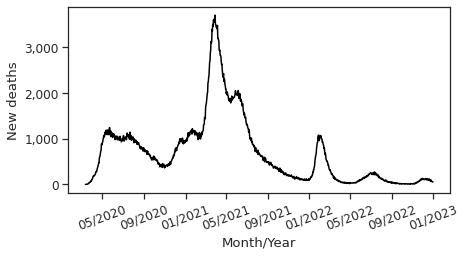

In [15]:
fig, ax = plt.subplots(figsize=(util.centimeter_to_inch(17.4), util.centimeter_to_inch(8.7)))

plt.plot(df_sim_deaths_general.DATA, df_sim_deaths_general.OBITOS_NOVOS, color='black')

ax.legend()

plt.ylabel('New deaths')
ax.xaxis.set_major_formatter(myFmt)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xlabel('Month/Year')
plt.xticks(rotation=20)
plt.savefig('images/serie_deaths.pdf', bbox_inches="tight", transparent=True)
plt.savefig('images/serie_deaths.eps', bbox_inches="tight", transparent=True)
plt.show()

In [16]:
df_sim_deaths_general.OBITOS_NOVOS.max()

3707.0

In [17]:
df_sim_deaths_general

,DATA,OBITOS_NOVOS,OBITOS
0,2020-03-12,1.0,1.0
1,2020-03-13,1.0,2.0
2,2020-03-14,0.0,2.0
3,2020-03-15,1.0,3.0
4,2020-03-16,5.0,8.0
...,...,...,...
1020,2022-12-27,67.0,700721.0
1021,2022-12-28,66.0,700787.0
1022,2022-12-29,57.0,700844.0
1023,2022-12-30,56.0,700900.0


## Time series by regions

In [18]:
df_covid_regions.loc[df_covid_regions.REGIAO == 'Centro-Oeste', 'REGIAO_EN'] = 'Midwestern'
df_covid_regions.loc[df_covid_regions.REGIAO == 'Norte', 'REGIAO_EN'] = 'North'
df_covid_regions.loc[df_covid_regions.REGIAO == 'Nordeste', 'REGIAO_EN'] = 'Northeast'
df_covid_regions.loc[df_covid_regions.REGIAO == 'Sudeste', 'REGIAO_EN'] = 'Southeast'
df_covid_regions.loc[df_covid_regions.REGIAO == 'Sul', 'REGIAO_EN'] = 'South'

In [19]:
df_covid_regions = df_covid_regions.sort_values('REGIAO_EN')

### Figure 1b

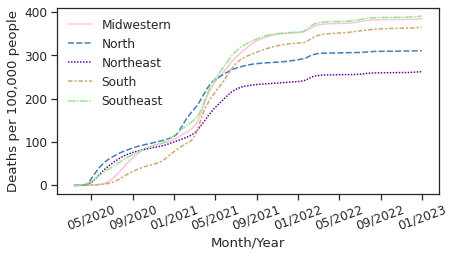

In [20]:
fig, ax = plt.subplots(figsize=(util.centimeter_to_inch(17.4), util.centimeter_to_inch(8.7)))
sns.lineplot(data=df_covid_regions, x="DATA", y="TAXA_OBITOS", markers=False, hue='REGIAO_EN', style='REGIAO_EN', palette=util.get_default_colors_categorical_seaborn())
plt.ylabel('Deaths per 100,000 people')
ax.xaxis.set_major_formatter(myFmt)
plt.xlabel('Month/Year')
plt.xticks(rotation=20)
plt.legend(title = None)

plt.savefig('images/serie_deaths_regions.pdf', bbox_inches="tight")
plt.savefig('images/serie_deaths_regions.eps', bbox_inches="tight")
plt.show()

## Boxplots by regions

In [22]:
df_covid_municipios_grouped = df_sim_covid_deaths_municipal_timeseries[['MUNICIPIO', 'CODIGO_MUNICIPIO_6', 'POPULACAO_2022', 'REGIAO', 'OBITOS_NOVOS']].groupby(['MUNICIPIO', 'CODIGO_MUNICIPIO_6', 'REGIAO', 'POPULACAO_2022']).sum()

In [23]:
df_covid_municipios_grouped = df_covid_municipios_grouped.reset_index()
df_covid_municipios_grouped['TAXA_OBITOS'] = df_covid_municipios_grouped.OBITOS_NOVOS / df_covid_municipios_grouped.POPULACAO_2022 * 100000
df_covid_municipios_grouped

,MUNICIPIO,CODIGO_MUNICIPIO_6,REGIAO,POPULACAO_2022,OBITOS_NOVOS,TAXA_OBITOS
0,Abadia de Goiás,520005,Centro-Oeste,19128.0,42,219.573400
1,Abadia dos Dourados,310010,Sudeste,6272.0,22,350.765306
2,Abadiânia,520010,Centro-Oeste,17228.0,65,377.292779
3,Abaetetuba,150010,Norte,158188.0,271,171.315144
4,Abaeté,310020,Sudeste,22675.0,46,202.866593
...,...,...,...,...,...,...
5557,Áurea,430155,Sul,3396.0,7,206.124853
5558,Ângulo,410115,Sul,3235.0,11,340.030912
5559,Érico Cardoso,290050,Nordeste,10604.0,6,56.582422
5560,Óbidos,150510,Norte,52229.0,162,310.172510


In [24]:
df_covid_municipios_grouped.loc[df_covid_municipios_grouped.REGIAO == 'Centro-Oeste', 'REGIAO_EN'] = 'Midwestern'
df_covid_municipios_grouped.loc[df_covid_municipios_grouped.REGIAO == 'Norte', 'REGIAO_EN'] = 'North'
df_covid_municipios_grouped.loc[df_covid_municipios_grouped.REGIAO == 'Nordeste', 'REGIAO_EN'] = 'Northeast'
df_covid_municipios_grouped.loc[df_covid_municipios_grouped.REGIAO == 'Sudeste', 'REGIAO_EN'] = 'Southeast'
df_covid_municipios_grouped.loc[df_covid_municipios_grouped.REGIAO == 'Sul', 'REGIAO_EN'] = 'South'

In [25]:
df_covid_municipios_grouped = df_covid_municipios_grouped.sort_values('REGIAO_EN')

### Figure 2

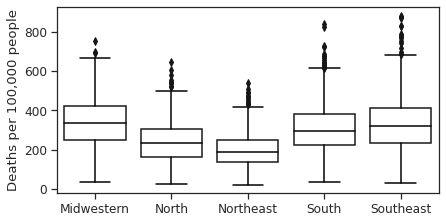

In [29]:
sns.set(font_scale=1.1)
sns.set_style("ticks")
sns.set_palette("gray")
fig, ax = plt.subplots(figsize=(util.centimeter_to_inch(17.4), util.centimeter_to_inch(8.7)))
sns.boxplot(data=df_covid_municipios_grouped, y='TAXA_OBITOS', x='REGIAO_EN', boxprops=dict(facecolor='white'))
plt.setp(ax.artists, edgecolor = 'black')
plt.setp(ax.lines, color='black')
plt.ylabel('Deaths per 100,000 people')
plt.xlabel(None)
plt.savefig('images/boxplot_deaths_municipalities.pdf', bbox_inches="tight")
plt.savefig('images/boxplot_deaths_municipalities.eps', bbox_inches="tight")
plt.show()